In [1]:
import numpy as np
import os
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob

# Import everything needed to process video clip for later
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Text(0.5,1,'Threshold Gradient')

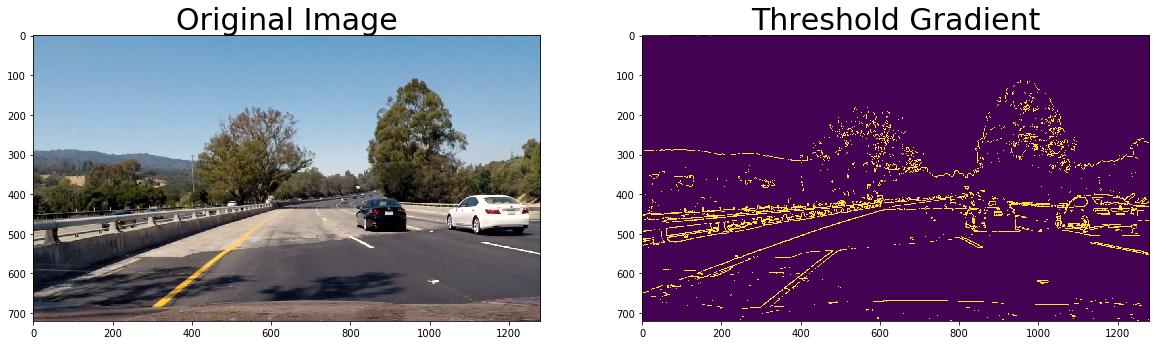

In [3]:
%matplotlib inline
image = mpimg.imread('test_images/test4.jpg')

def mag_thresh(img, sobel_kernel, mag_thresh):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude
    mag = np.sqrt(np.square(sobelx)+np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 200))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mag_binary)
ax2.set_title('Threshold Gradient', fontsize=30)

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # Initialize all others not carried over between first detections
        self.reset()

    def reset(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # recent polynomial coefficients
        self.recent_fit = []
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        # counter to reset after 5 iterations if issues arise
        self.counter = 0        

    def count_check(self):
        ''' 
        Resets the line class upon failing five times in a row.
        '''
        # Increment the counter - NOT IMPLEMENTED
        #self.counter += 1
        # Reset if failed five times
        if self.counter >= 5:
            self.reset()

    def fit_line(self, x_points, y_points, first_try=True):
        '''
        Fit a second order polynomial to the line.
        The challenge videos sometimes throws errors, so the below trys first.
        Upon the error being thrown, either reset the line or add to counter.
        '''
        try: 
            n = 5
            self.current_fit = np.polyfit(y_points, x_points, 2)
            self.all_x = x_points
            self.all_y = y_points
            self.recent_fit.append(self.current_fit)
            if len(self.recent_fit) > 1:
                self.diffs = (self.recent_fit[-2] - self.recent_fit[-1]) / self.recent_fit[-2]
            self.recent_fit = self.recent_fit[-n:]
            self.best_fit = np.mean(self.recent_fit, axis = 0)
            line_fit = self.current_fit
            self.detected = True
            self.counter = 0

            return line_fit

        except (TypeError, np.linalg.LinAlgError):
            line_fit = self.best_fit
            if first_try == True:
                self.reset()
            else:
                self.count_check()

            return line_fit

def calibration(cal_image_loc):
    '''
    Perform camera calibration.
    '''
    # Load in the chessboard calibration images to a list
    calibration_images = []

    for fname in cal_image_loc:
        img = mpimg.imread(fname)
        calibration_images.append(img)

    # Prepare object points
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays for later storing object points and image points
    objpoints = []
    imgpoints = []

    # Iterate through images for their points
    for image in calibration_images:
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(image, (9, 6), corners, ret)

    # Returns camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
                                                       gray.shape[::-1], None, 
                                                       None)

    return mtx, dist

def pipeline(img, mtx, dist, s_thresh=(125, 255), sx_thresh=(10, 100), 
             R_thresh = (200, 255), sobel_kernel = 3):
    ''' 
    Pipeline to create binary image.
    This version uses thresholds on the R & S color channels and Sobelx.
    Binary activation occurs where any two of the three are activated.
    '''
    distorted_img = np.copy(img)
    dst = cv2.undistort(distorted_img, mtx, dist, None, mtx)
    # Pull R
    R = dst[:,:,0]
    
    # Convert to HLS colorspace
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobelx - takes the derivate in x, absolute value, then rescale
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) 
             & (scaled_sobelx <= sx_thresh[1])] = 1

    # Threshold R color channel
    R_binary = np.zeros_like(R)
    R_binary[(R >= R_thresh[0]) & (R <= R_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # If two of the three are activated, activate in the binary image
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (sxbinary == 1)) 
                     | ((sxbinary == 1) & (R_binary == 1))
                     | ((s_binary == 1) & (R_binary == 1))] = 1

    return combined_binary

def birds_eye(img, mtx, dist):
    '''
    Birds eye first undistorts the image, using the calibration from earlier.
    Next, using defined source image points and destination points,
    it will transform the image as if the road was viewed from above,
    like a bird would see. Returns the birds eye image and transform matrix.
    '''
    # Put the image through the pipeline to get the binary image
    binary_img = pipeline(img, mtx, dist)

    # Grab the image shape
    img_size = (binary_img.shape[1], binary_img.shape[0])

    # Source points - defined area of lane line edges
    src = np.float32([[690,450],[1110,img_size[1]],[175,img_size[1]],[595,450]])

    # 4 destination points to transfer
    offset = 300 # offset for dst points
    dst = np.float32([[img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]],
                      [offset, img_size[1]],[offset, 0]])
    
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Use cv2.warpPerspective() to warp the image to a top-down view
    top_down = cv2.warpPerspective(binary_img, M, img_size)

    return top_down, M

def sliding_window(x_current, margin, minpix, nonzerox, nonzeroy, 
                   win_y_low, win_y_high, window_max, counter, side):
    '''
    Creates a window, then checks for non-zero value pixels within it.
    If there are more than minpix, the window gets re-centered to their mean.
    Lastly, if at least five windows have been used, check whether we have
    hit the outside of the image.
    '''
    # Identify window boundaries
    win_x_low = x_current - margin
    win_x_high = x_current + margin
    # Identify the nonzero pixels in x and y within the window
    good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
                 & (nonzerox >= win_x_low) 
                 & (nonzerox < win_x_high)).nonzero()[0]
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_inds) > minpix:
        x_current = np.int(np.mean(nonzerox[good_inds]))
    if counter >= 5:
        if win_x_high > window_max or win_x_low < 0:
            if side == 'left':
                left_tracker = False
            else:
                right_tracker = False

    return good_inds, x_current

def first_lines(img, mtx, dist):
    '''
    First Lines uses the birds eye image from above,
    creates a histogram of where the binary activations occur,
    and uses sliding windows along the peak areas to estimate
    where the lane lines are.
    '''
    # Load the birds eye image and transform matrix from birds_eye
    binary_warped, perspective_M = birds_eye(img, mtx, dist)
    
    # Histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 35
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_tracker = True
    right_tracker = True
    counter = 0

    # Step through the windows one by one
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        window_max = binary_warped.shape[1]
        if left_tracker == True and right_tracker == True:
            good_left_inds, leftx_current = sliding_window(leftx_current, margin, minpix, nonzerox, nonzeroy, 
                                                           win_y_low, win_y_high, window_max, counter, 'left')
            good_right_inds, rightx_current = sliding_window(rightx_current, margin, minpix, nonzerox, nonzeroy, 
                                                             win_y_low, win_y_high, window_max, counter, 'right')
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            counter += 1
        elif left_tracker == True:
            good_left_inds, leftx_current = sliding_window(leftx_current, margin, minpix, nonzerox, nonzeroy, 
                                                           win_y_low, win_y_high, window_max, counter, 'left')
            # Append these indices to the list
            left_lane_inds.append(good_left_inds)
        elif right_tracker == True:
            good_right_inds, rightx_current = sliding_window(rightx_current, margin, minpix, nonzerox, nonzeroy, 
                                                             win_y_low, win_y_high, window_max, counter, 'right')
            # Append these indices to the list
            right_lane_inds.append(good_right_inds)
        else:
            break

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each line
    left_fit = left_line.fit_line(leftx, lefty, True)
    right_fit = right_line.fit_line(rightx, righty, True)

def second_ord_poly(line, val):
    '''
    Simple function being used to help calculate distance from center.
    Only used within Draw Lines below. Finds the base of the line at the
    bottom of the image.
    '''
    a = line[0]
    b = line[1]
    c = line[2]
    formula = (a*val**2)+(b*val)+c

    return formula

def draw_lines(img, mtx, dist):
    '''
    Draw Lines will first check whether the lines are detected.
    If not, go back up to First Lines. If they are, we do not have to search
    the whole image for the lines. We can then draw the lines,
    as well as detect where the car is in relation to the middle of the lane,
    and what type of curvature it is driving at.
    '''
    # Pull in the image
    binary_warped, perspective_M = birds_eye(img, mtx, dist)

    # Check if lines were last detected; if not, re-run first_lines
    if left_line.detected == False or right_line.detected == False:
        first_lines(img, mtx, dist)

    # Set the fit as the current fit for now
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit

    # Again, find the lane indicators
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Set the x and y values of points on each line
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each again.
    left_fit = left_line.fit_line(leftx, lefty, False)
    right_fit = right_line.fit_line(rightx, righty, False)

    # Generate x and y values for plotting
    fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Calculate the pixel curve radius
    y_eval = np.max(fity)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_line.all_y*ym_per_pix, 
                             left_line.all_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_line.all_y*ym_per_pix, 
                              right_line.all_x*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_rad = round(np.mean([left_curverad, right_curverad]),0)
    rad_text = 'Radius of Curvature = {}(m)'.format(avg_rad)

    # Calculating middle of the image, aka where the car camera is
    middle_of_image = img.shape[1] / 2
    car_position = middle_of_image * xm_per_pix

    # Calculating middle of the lane
    left_line_base = second_ord_poly(left_fit_cr, img.shape[0] * ym_per_pix)
    right_line_base = second_ord_poly(right_fit_cr, img.shape[0] * ym_per_pix)
    lane_mid = (left_line_base+right_line_base)/2

    # Calculate distance from center and list differently based on left or right
    dist_from_center = lane_mid - car_position
    if dist_from_center >= 0:
        center_text = '{} meters left of center'.format(round(dist_from_center,2))
    else:
        center_text = '{} meters right of center'.format(round(-dist_from_center,2))
        
    # List car's position in relation to middle on the image and radius of curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, center_text, (10,50), font, 1,(255,255,255),2)
    cv2.putText(img, rad_text, (10,100), font, 1,(255,255,255),2)

    # Invert the transform matrix from birds_eye (to later make the image back 
    #   to normal below)
    Minv = np.linalg.inv(perspective_M)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective 
    #   matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    return result

def process_image(image, mtx, dist):
    '''
    This processes through everything above.
    Will return the image with car position, lane curvature, and 
      lane lines drawn.
    '''
    result = draw_lines(image, mtx, dist)
    
    return result


In [4]:
def main():
    # Grab location of calibration images
    cal_image_loc = glob.glob('camera_cal/*.jpg')

    # Calibrate camera and return calibration data
    mtx, dist = calibration(cal_image_loc)

    # Convert to video
    # vid_output is where the image will be saved to
    vid_output = 'Final_Result.mp4'

    # The file referenced in clip1 is the original video before anything has 
    #   been done to it
    clip1 = VideoFileClip('project_video.mp4')

    # NOTE: this function expects color images
    vid_clip = clip1.fl_image(lambda image: process_image(image, mtx, dist))
    vid_clip.write_videofile(vid_output, audio=False)

if __name__ == '__main__':
    # Set the class lines equal to the variables used above
    left_line = Line()
    right_line = Line()
    main()

[MoviePy] >>>> Building video Final_Result.mp4
[MoviePy] Writing video Final_Result.mp4


100%|█████████▉| 1260/1261 [04:24<00:00,  4.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Final_Result.mp4 

